In [1]:
import tensorflow as tf
print ("TensorFlow version: " + tf.__version__)

TensorFlow version: 2.0.0


In [2]:
import keras

Using TensorFlow backend.


In [3]:
import numpy as np
import os, glob, shutil
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

TRAIN_BEN_IMAGE_PATH='./Train/0/'
TRAIN_MAL_IMAGE_PATH='./Train/1/'

VALID_BEN_IMAGE_PATH='./Valid/0/'
VALID_MAL_IMAGE_PATH='./Valid/1/'

TEST_BEN_IMAGE_PATH='./Test/0/'
TEST_MAL_IMAGE_PATH='./Test/0/'

train_ben_image_list = sorted(glob.glob(TRAIN_BEN_IMAGE_PATH + '*.png'))
train_mal_image_list = sorted(glob.glob(TRAIN_MAL_IMAGE_PATH + '*.png'))

valid_ben_image_list = sorted(glob.glob(VALID_BEN_IMAGE_PATH + '*.png'))
valid_mal_image_list = sorted(glob.glob(VALID_MAL_IMAGE_PATH + '*.png'))

test_ben_image_list = sorted(glob.glob(TEST_BEN_IMAGE_PATH + '*.png'))
test_mal_image_list = sorted(glob.glob(TEST_MAL_IMAGE_PATH + '*.png'))


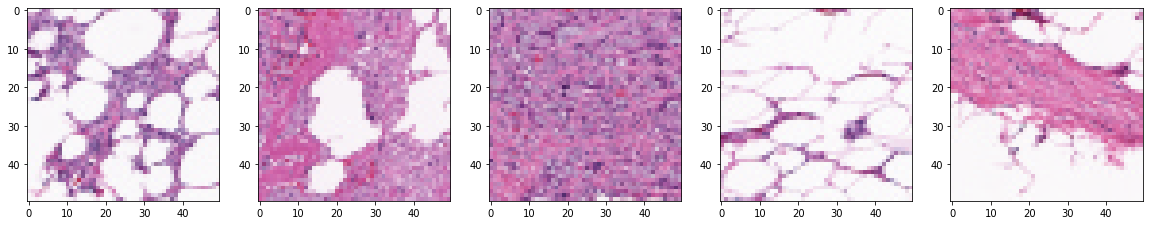

In [4]:
# Displaying benign images
ben_images = []
for i in range(5):
    ben_images.append(mpimg.imread(train_ben_image_list[i]))

plt.figure(figsize=(20,10))
columns = 5
for i, image in enumerate(ben_images):
    plt.subplot(len(ben_images) / columns + 1, columns, i + 1)
    plt.imshow(image)

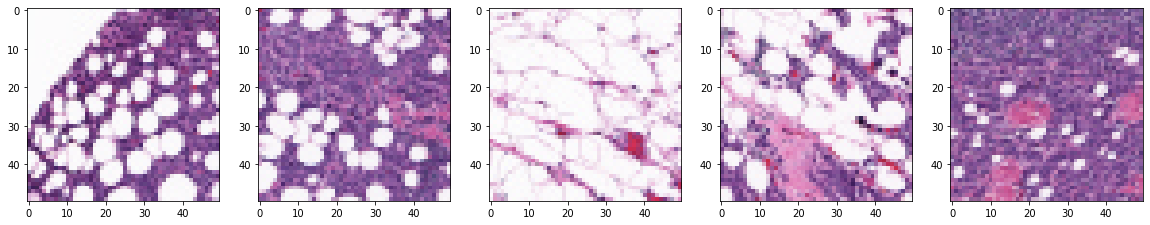

In [5]:
# Displaying malignant images    
mal_images = []
for i in range(5):
    mal_images.append(mpimg.imread(train_mal_image_list[i]))

plt.figure(figsize=(20,10))
columns = 5
for i, image in enumerate(mal_images):
    plt.subplot(len(mal_images) / columns + 1, columns, i + 1)
    plt.imshow(image)

In [4]:
# Constants used for training
LEARNING_RATE = 0.0001
NUM_EPOCHS = 10
BATCH_SIZE = 32
IMAGE_SIZE = 48
CHANNELS = 3
MODEL_WEIGHTS = './Model_Weights/'

# Import necessary libraries
from keras.models import Model
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from keras.callbacks import Callback
from keras.models import load_model
from keras import optimizers
from keras import backend as K
from keras.layers import Dropout, Flatten, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, ReLU, Dense, Activation
from keras.utils.data_utils import Sequence
from keras.utils import np_utils
from sklearn.metrics import classification_report


In [5]:
# initialize the training data augmentation object
trainAug = ImageDataGenerator(rescale=1 / 255.0)

# initialize the validation data augmentation object
valAug = ImageDataGenerator(rescale=1 / 255.0)

# initialize the testing data augmentation object
testAug = ImageDataGenerator(rescale=1 / 255.0)

# initialize the training generator
trainGen = trainAug.flow_from_directory(
    './Train/',
    class_mode='binary',
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    color_mode='rgb',
    shuffle=True,
    batch_size=BATCH_SIZE)

# initialize the validation generator
valGen = valAug.flow_from_directory(
    './Valid/',
    class_mode='binary',
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    color_mode='rgb',
    shuffle=False,
    batch_size=BATCH_SIZE)

# initialize the validation generator
testGen = testAug.flow_from_directory(
    './Test/',
    class_mode='binary',
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    color_mode='rgb',
    shuffle=False,
    batch_size=BATCH_SIZE)

Found 4460 images belonging to 2 classes.
Found 560 images belonging to 2 classes.
Found 560 images belonging to 2 classes.


In [7]:
# Build our own model
# Reference: https://www.pyimagesearch.com/2018/09/10/keras-tutorial-how-to-get-started-with-keras-deep-learning-and-python/

model = Sequential()
inputShape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)

# CONV => RELU => POOL layer set
model.add(Conv2D(32, (3, 3), padding='same', input_shape=inputShape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# (CONV => RELU) * 2 => POOL layer set
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# (CONV => RELU) * 3 => POOL layer set
model.add(Conv2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# first (and only) set of FC => RELU layers
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))

# softmax classifier
model.add(Dense(1))
model.add(Activation('sigmoid'))


In [15]:
# Compile the model
print('Training the Model')
optimizer = optimizers.Adam(learning_rate = LEARNING_RATE)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
mc = ModelCheckpoint(mode='max', filepath=MODEL_WEIGHTS + 'Weights_.{epoch:02d}-{val_accuracy:.4f}.h5', 
                     monitor='val_accuracy', save_best_only='True', save_weights_only='True', verbose=1)
model.summary() 

total_num_train = len(train_ben_image_list) + len(train_mal_image_list)
total_num_valid = len(valid_ben_image_list) + len(valid_mal_image_list)
total_num_test = len(test_ben_image_list) + len(test_mal_image_list)

steps_per_epoch = np.ceil(total_num_train / BATCH_SIZE).astype("int32")
print('Steps for Training Epoch: ', steps_per_epoch)

validation_steps = np.ceil(total_num_valid / BATCH_SIZE).astype("int32")
print('Steps for Validation Epoch: ', validation_steps)

testing_steps = np.ceil(total_num_test / BATCH_SIZE).astype("int32")
print('Steps for Testing: ', testing_steps)


Training the Model
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 48, 48, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 48, 48, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
activation_2 (Activation)    (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None,

In [10]:
# Start Training
history = model.fit_generator(trainGen,
                              steps_per_epoch=steps_per_epoch,
                              validation_data = valGen,
                              validation_steps = validation_steps,
                              epochs=NUM_EPOCHS,
                              callbacks=[mc])

Epoch 1/10
140/140 [==============================] - 40s 283ms/step - loss: 0.6711 - accuracy: 0.5621 - val_loss: 0.5549 - val_accuracy: 0.7018

Epoch 00001: val_accuracy improved from -inf to 0.70179, saving model to ./Model_Weights/Weights_.01-0.7018.h5
Epoch 2/10
140/140 [==============================] - 44s 314ms/step - loss: 0.5555 - accuracy: 0.7278 - val_loss: 0.2517 - val_accuracy: 0.6196

Epoch 00002: val_accuracy did not improve from 0.70179
Epoch 3/10
140/140 [==============================] - 57s 409ms/step - loss: 0.5324 - accuracy: 0.7437 - val_loss: 0.2928 - val_accuracy: 0.6607

Epoch 00003: val_accuracy did not improve from 0.70179
Epoch 4/10
140/140 [==============================] - 51s 362ms/step - loss: 0.5248 - accuracy: 0.7531 - val_loss: 0.3533 - val_accuracy: 0.7500

Epoch 00004: val_accuracy improved from 0.70179 to 0.75000, saving model to ./Model_Weights/Weights_.04-0.7500.h5
Epoch 5/10
140/140 [==============================] - 47s 334ms/step - loss: 0.51

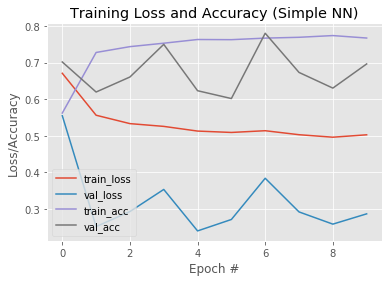

In [11]:
# Drawing training history
N = np.arange(0, NUM_EPOCHS)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, history.history["loss"], label="train_loss")
plt.plot(N, history.history["val_loss"], label="val_loss")
plt.plot(N, history.history["accuracy"], label="train_acc")
plt.plot(N, history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy (Simple NN)")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig('./Trainig_history')

In [12]:
print("[Testing network...")
testGen.reset()
predIdxs = model.predict_generator(testGen, steps=testing_steps)
print(predIdxs.shape)

[Testing network...
(560, 1)


In [13]:
print(testGen.classes)
predIdxs[predIdxs<0.5] = 0
predIdxs[predIdxs>=0.5] = 1
target_names = ['Benign', 'Malignant']
print(classification_report(testGen.classes, predIdxs, target_names=target_names))

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 

In [14]:
saved_weights_list = sorted(glob.glob(MODEL_WEIGHTS + '*.h5'), key=os.path.getmtime)
print(saved_weights_list)
print(saved_weights_list[-1])

['./Model_Weights/Weights_.01-0.7018.h5', './Model_Weights/Weights_.04-0.7500.h5', './Model_Weights/Weights_.07-0.7804.h5']
./Model_Weights/Weights_.07-0.7804.h5


In [15]:
model.load_weights(saved_weights_list[-1])
testGen.reset()
predIdxs = model.predict_generator(testGen, steps=testing_steps)

predIdxs[predIdxs<0.5] = 0
predIdxs[predIdxs>=0.5] = 1

target_names = ['Benign', 'Malignant']
print(classification_report(testGen.classes, predIdxs, target_names=target_names))

              precision    recall  f1-score   support

      Benign       0.83      0.75      0.79       280
   Malignant       0.77      0.84      0.81       280

    accuracy                           0.80       560
   macro avg       0.80      0.80      0.80       560
weighted avg       0.80      0.80      0.80       560



In [ ]:
!pip install -U efficientnet

In [8]:
import efficientnet.keras as efn 
eff = efn.EfficientNetB0(weights='imagenet', include_top=False, input_shape=inputShape)
eff.summary()

Model: "efficientnet-b0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 48, 48, 3)    0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 24, 24, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 24, 24, 32)   128         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 24, 24, 32)   0           stem_bn[0][0]                    
____________________________________________________________________________________

In [9]:
input = eff.input
x = GlobalAveragePooling2D()(eff.output)
print(x.get_shape())
bsize, c = x.get_shape().as_list()
x1 = Dense(c//2, activation='relu')(x)
x2 = Dropout(0.5)(x1)
x3 = Dense(1, activation='sigmoid')(x2)

output = x3
print('Output Shape: ', output.get_shape())

model2 = Model(input, output)
model2.name = 'EffNet_b1'

(None, 1280)
Output Shape:  (None, 1)


In [20]:
model2.summary()
for layer in model2.layers[:-4]:
    layer.trainable = False

Model: "EffNet_b1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 48, 48, 3)    0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 24, 24, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 24, 24, 32)   128         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 24, 24, 32)   0           stem_bn[0][0]                    
__________________________________________________________________________________________

In [11]:
# Compile the model2
MODEL_WEIGHTS2 = './Model_Weights2/'
print('Compiling the Model2')
optimizer = optimizers.Adam(learning_rate = 0.01)
model2.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
mc = ModelCheckpoint(mode='max', filepath=MODEL_WEIGHTS2 + 'Frozen_Weights_.{epoch:02d}-{val_accuracy:.4f}.h5', 
                     monitor='val_accuracy', save_best_only='True', save_weights_only='True', verbose=1)

Compiling the Model2


In [22]:
trainGen.reset()
valGen.reset()
history = model2.fit_generator(trainGen,
                              steps_per_epoch=steps_per_epoch,
                              validation_data = valGen,
                              validation_steps = validation_steps,
                              epochs=1,
                              callbacks=[mc])

Epoch 1/1
140/140 [==============================] - 16s 113ms/step - loss: 0.8232 - accuracy: 0.6594 - val_loss: 11.7095 - val_accuracy: 0.5000

Epoch 00001: val_accuracy improved from -inf to 0.50000, saving model to ./Model_Weights2/Frozen_Weights_.01-0.5000.h5


In [12]:
for layer in model2.layers:
    layer.trainable = True

optimizer = optimizers.Adam(learning_rate = 0.01*0.1)
model2.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
mc = ModelCheckpoint(mode='max', filepath=MODEL_WEIGHTS2 + 'Unfrozen_Weights_.{epoch:02d}-{val_accuracy:.4f}.h5', 
                     monitor='val_accuracy', save_best_only='True', save_weights_only='True', verbose=1)



In [ ]:
trainGen.reset()
valGen.reset()
history = model2.fit_generator(trainGen,
                              steps_per_epoch=steps_per_epoch,
                              validation_data = valGen,
                              validation_steps = validation_steps,
                              epochs=NUM_EPOCHS,
                              callbacks=[mc])

Epoch 1/10
140/140 [==============================] - 73s 523ms/step - loss: 0.5845 - accuracy: 0.7430 - val_loss: 0.3188 - val_accuracy: 0.7071

Epoch 00001: val_accuracy improved from -inf to 0.70714, saving model to ./Model_Weights2/Unfrozen_Weights_.01-0.7071.h5
Epoch 2/10
140/140 [==============================] - 59s 421ms/step - loss: 0.4075 - accuracy: 0.8271 - val_loss: 0.4870 - val_accuracy: 0.7714

Epoch 00002: val_accuracy improved from 0.70714 to 0.77143, saving model to ./Model_Weights2/Unfrozen_Weights_.02-0.7714.h5
Epoch 3/10
140/140 [==============================] - 78s 560ms/step - loss: 0.3449 - accuracy: 0.8592 - val_loss: 1.4500 - val_accuracy: 0.7643

Epoch 00003: val_accuracy did not improve from 0.77143
Epoch 4/10
140/140 [==============================] - 78s 557ms/step - loss: 0.2847 - accuracy: 0.8892 - val_loss: 1.1735 - val_accuracy: 0.7661

Epoch 00004: val_accuracy did not improve from 0.77143
Epoch 5/10
140/140 [==============================] - 75s 534

In [13]:
saved_weights_list = sorted(glob.glob(MODEL_WEIGHTS2 + '*.h5'), key=os.path.getmtime)
print(saved_weights_list)
print(saved_weights_list[-1])

['./Model_Weights2/Frozen_Weights_.01-0.5000.h5', './Model_Weights2/Unfrozen_Weights_.01-0.7071.h5', './Model_Weights2/Unfrozen_Weights_.02-0.7714.h5', './Model_Weights2/Unfrozen_Weights_.07-0.7875.h5']
./Model_Weights2/Unfrozen_Weights_.07-0.7875.h5


In [16]:
model2.load_weights(saved_weights_list[-1])
testGen.reset()
predIdxs = model2.predict_generator(testGen, steps=testing_steps)

predIdxs[predIdxs<0.5] = 0
predIdxs[predIdxs>=0.5] = 1

target_names = ['Benign', 'Malignant']
print(classification_report(testGen.classes, predIdxs, target_names=target_names))

              precision    recall  f1-score   support

      Benign       0.81      0.82      0.82       280
   Malignant       0.82      0.81      0.81       280

    accuracy                           0.81       560
   macro avg       0.81      0.81      0.81       560
weighted avg       0.81      0.81      0.81       560

